# Fitting radial profiles to galaxies

### Isaac Cheng - October 2021

Read Section 4.5 ("CO Radial Profiles") of the VERTICO paper and also look at Table 1. Can
calculate eccentricity of ellipse from position angle + inclination. Also take a look at
[`photutils.aperture.EllipticalAnnulus`](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAnnulus.html)
and [this tutorial](https://photutils.readthedocs.io/en/stable/aperture.html).
Fit annuli starting from the centre, moving outward. The semiminor axis should be at least
the beam width for the VERTICO data. Results should be similar to Figure 9 of the VERTICO
paper.


In [72]:
# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import astropy.units as u
import astropy.coordinates as coord
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import fits_plot_utils as utils
from photutils.aperture import aperture_photometry, EllipticalAnnulus, EllipticalAperture
import dill
from radio_beam import Beam
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Ellipse

/arc/home/IsaacCheng/coop_f2021/warmup


In [82]:
def calc_eccentricity(inclination):
    """
    Calculates the eccentricities of galaxies given their inclinations. Assumes galaxies
    are perfectly circular disks (reasonable for spiral galaxies, not necessarily true for
    other morphologies).
    
    The inclination of a galaxy, i, is defined as the ratio of its observed (semi-)minor
    axis, b, to its observed (semi-)major axis, a:
                                    cos(i) := b/a
    Thus, the eccentricity, e, of a galaxy can be directly calculated from its
    inclination:
                        e := sqrt(1 - (b/a)^2) = sqrt(1 - cos^2(i))
    
    Parameters:
      inclination :: float or array-like
        The inclinations of the galaxies in degrees
    
    Returns: eccentricity
      eccentricity :: float or array-like
        The eccentricities of the galaxies
    """
    cosi = np.cos(np.deg2rad(inclination))
    return np.sqrt(1 - cosi * cosi)


# def get_annulus_quantities(data, annulus, avg_func=np.nanmedian):
#     """
#     Parameters:
#       annulus :: `photutils.aperture.EllipticalAnnulus` object
#     Returns: radius, average
#     """


def calc_snr_annuli(signal, annuli, noise=None, include_bad=True, phot_kwargs=None):
    """
    Calculates signal (and optionally noise) of data enclosed in each annulus. If more
    than one annulus provided, all annuli must have the same centre.
    
    TODO: finish docstring
    
    Parameters:
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from calculation.
    
    Returns: tot_signal, tot_noise
      tot_signal, tot_noise :: float
        The total signal and noise of the data in the annulus. N.B. the signal is a
        straight arithmetic sum but the noise is summed in quadrature.
    """
    if noise is not None:
        mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
    else:
        mask = ~np.isfinite(signal)
    if include_bad:
        # Set non-detections and bad pixels to zero
        signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=0.0)
        if noise is not None:
            noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=0.0)
        aper_mask = None  # include all pixels
    else:
        # Skip non-detections and bad pixels from summation
        aper_mask = mask
    # ann_mask = annulus.to_mask(method=method)
    if phot_kwargs is None:
        phot_results = aperture_photometry(signal, annuli, error=noise, mask=aper_mask)
        # # Add noise in quadrature
        # tot_noise = ann_mask.multiply(noise * noise)
        # tot_noise = np.nansum(tot_noise)
        # tot_noise = np.sqrt(tot_noise)
    else:
        phot_results = aperture_photometry(
            signal, annuli, error=noise, mask=aper_mask, **phot_kwargs
        )
    # print(phot_results.keys)
    # print(phot_results)
    return phot_results["aperture_sum"].value, phot_results["aperture_sum_err"].value


def fit_annuli(
    center,
    i,
    pa,
    min_width,
    min_width_ax="minor",
    n_annuli=None,
    data=None,
    noise=None,
    snr_cutoff=None,
    wcs=None,
):
    """
    Work in progress. Only have n_annuli implemented so far
    """
    if isinstance(center, coord.SkyCoord):
        if wcs is None:
            raise ValueError("wcs must be provided if center is not in pixel coordinates")
        center = wcs.world_to_pixel(center)
    e = calc_eccentricity(i)  # eccentricity of galaxy
    pa = np.deg2rad((pa + 90) % 360.0)  # PA starts at North and increases Eastward (CCW)
    annuli, a_ins, a_outs, b_ins, b_outs = [], [], [], [], []
    b_to_a_factor = 1 / np.sqrt(1 - e * e)
    if n_annuli is not None:
        if n_annuli < 1 or not isinstance(n_annuli, int):
            raise ValueError("n_annulus must be an integer > 0")
        for i in range(n_annuli):
            # Assume min_width_ax == "minor"
            b_in = i * min_width
            a_in = b_in * b_to_a_factor
            if min_width_ax == "major":
                b_in, a_in = a_in, b_in
            elif min_width_ax != "minor":
                raise ValueError("min_width_ax must be either 'major' or 'minor'")
            b_out = b_in + min_width
            a_out = b_out * b_to_a_factor
            a_ins.append(a_in)
            a_outs.append(a_out)
            b_ins.append(b_in)
            b_outs.append(b_out)
            # print(i, a_in, a_out, b_in, b_out)
            if a_in == 0 and b_in == 0:
                annulus = EllipticalAperture(center, a_out, b_out, theta=pa)
            else:
                annulus = EllipticalAnnulus(
                    center, a_in=a_in, b_in=b_in, a_out=a_out, b_out=b_out, theta=pa
                )
            annuli.append(annulus)
        annuli, a_ins, a_outs, b_ins, b_outs = np.asarray(
            (annuli, a_ins, a_outs, b_ins, b_outs)
        )
        return annuli, a_ins, a_outs, b_ins, b_outs
    else:
        raise ValueError("n_annuli must be provided. Sorry. This is a WIP")


def get_beam_size(header):
    """
    Assumes pixel is square.

    TODO: finish docstring
    """
    beam = Beam.from_fits_header(header)
    # Assume square pixels
    deg_per_px = proj_plane_pixel_scales(WCS(header).celestial)[0] * u.deg
    #
    beam_major = (beam.major.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_minor = (beam.minor.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_pa = (beam.pa + 90.0 * u.deg).to(u.deg).value  # PA starts at N and increases CCW
    return beam_major, beam_minor, beam_pa


def calc_radius(a_in, a_out, b_in, b_out):
    """
    The radius of an annulus is defined as the arithmetic mean of the annulus' midpoints
    along the semimajor & semiminor axes
    """
    a_mid = (a_in + a_out) / 2
    b_mid = (b_in + b_out) / 2
    return (a_mid + b_mid) / 2


def radio_radial_profile(
    data,
    header,
    center,
    pa,
    i,
    noise=None,
    n_annuli=1,
    wcs=None,
    include_bad=True,
    phot_kwargs=None,
):
    beam_major, beam_minor, beam_pa = get_beam_size(header)
    min_width = np.max((beam_major, beam_minor))
    annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
        center, i, pa, min_width, n_annuli=n_annuli, wcs=wcs
    )
    radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
    tot_data, tot_noise = [], []
    for annulus in annuli:
        annulus_data, annulus_noise = calc_snr_annuli(
            data, annulus, noise, include_bad=include_bad, phot_kwargs=phot_kwargs
        )
        tot_data.append(float(annulus_data))
        tot_noise.append(float(annulus_noise))
    tot_data, tot_noise = np.asarray((tot_data, tot_noise))
    return tot_data, tot_noise, radii, annuli, a_ins, a_outs, b_ins, b_outs


In [83]:

# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Msolpc-2.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [108]:
(
    vcc792_sum_data,
    vcc792_sum_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    n_annuli=7,
    wcs=wcs_co,
)

[1.47377447e+02 6.29918553e+01 3.88629459e+01 3.15356729e+01
 3.39149571e+00 4.05410621e-14 3.10975769e-14]
[3.92449664e-01 1.84227106e-01 1.27699038e-01 9.88459746e-02
 3.56050316e-02 2.75892364e-09 2.22040059e-09]


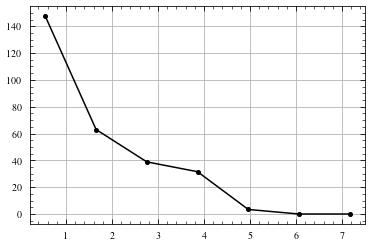

In [111]:
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
annuli_area = (
    np.array([annulus.area for annulus in vcc792_annuli])
    * pc_per_px[0].value / 1000
    * pc_per_px[1].value / 1000
)
avg_co = vcc792_sum_data / annuli_area
avg_co_err = vcc792_sum_noise / annuli_area
print(avg_co)
print(avg_co_err)
#
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=avg_co,
    # yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
# ax.semilogy()
# ebar[-1][0].set_linestyle("--")
plt.show()


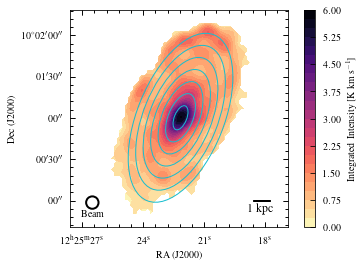

In [114]:
fig, ax = plt.subplots(subplot_kw={"projection": wcs_co})
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
cbar = fig.colorbar(img)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width,
        height=height,
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
xbeam, ybeam = 8, 9
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=2, zorder=2
)
ax.add_patch(ellipse)
xtxt, ytxt = (xbeam - 4, ybeam - 5)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc")
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

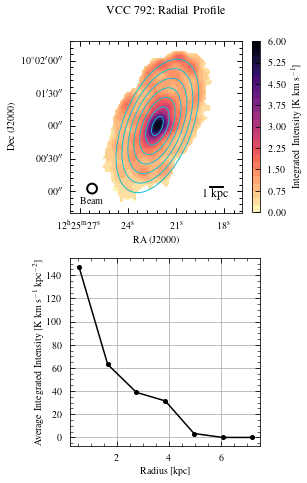

In [141]:
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width,
        height=height,
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
xbeam, ybeam = 10, 11
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=2, zorder=2
)
ax.add_patch(ellipse)
xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc")
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
annuli_area = (
    np.array([annulus.area for annulus in vcc792_annuli])
    * pc_per_px[0].value / 1000
    * pc_per_px[1].value / 1000
)
avg_co = vcc792_sum_data / annuli_area
avg_co_err = vcc792_sum_noise / annuli_area
#
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=avg_co,
    # yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
# ebar[-1][0].set_linestyle("--")
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig("imgs/vcc792_rad_prof_Kkms.pdf")
plt.show()